In [1]:
%matplotlib inline

In [2]:
import glob
import time
import os

import numpy as np
import matplotlib.pyplot as plt

import astropy.io.fits as pyfits
import drizzlepac

import grizli

No TEAL-based tasks available for this package!
The following task in the fitsblender package can be run with TEAL:
                                  blendheaders                                  
The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol


### Data and directory structure ###
Download FLT (WFC3/IR) or FLC (ACS WFC or WFC3/UVIS) products.  A typical working directory structure is something like

 * `./RAW/` - Put downloaded files here.  The scripts will make copies of these files and leave these untouched.  Some scripts have default parameters that look for `RAW` (or rather, `../RAW/`) specifically, so just use that unless you plan to change the scripts elsewhere.
 * `./Prep/` - General working directory for processing & analysis.  Can be called anything. 
 * `./Persistence/` - (optional) place to put persistence products downloaded from https://archive.stsci.edu/prepds/persist/search.php

### GOODS-S ERS Demonstration Data ###
The WFC3 ERS program ([GO-11359](http://archive.stsci.edu/proposal_search.php?id=11359&mission=hst&sci_instrume=WFC3)) offers a good demonstration of the Grizli WFC3 processing, with two orbits in each of the two WFC3/IR grisms G102 and G141, within the well-studied GOODS-S/CANDELS/3D-HST survey field.  Download the demonstration data:
```bash
cd [some working directory]
wget http://www.stsci.edu/~brammer/Grizli/Files/grizli_ERS_demo.tar.gz
tar xzvf grizli_ERS_demo.tar.gz
```
Unpacking the tarfile produces the directories as above and unpacks the ERS grism (and direct) FLT exposures in the `RAW` directory.  Note that the FLT files have been reprocessed from the original RAW images using [reprocess_wfc3.py](https://github.com/gbrammer/wfc3/blob/master/reprocess_wfc3.py) to account for variable backgrounds during the grism exposures.

In [3]:
# os.chdir([where you downloaded the ERS data])
os.chdir('Prep')

### File handling ###
The pipeline products are typically put in a `../RAW` directory, though in principle they can be found anywhere.  `Grizli` provides utilities to load lists of FLT exposures and parse their header information to group them into visits / filters.  In the example below, the parse script found four exposures in each of the filters F098M, F140W, G102 and G141.

In [4]:
files = glob.glob('../RAW/*flt.fits')
info = grizli.utils.get_flt_info(files)
visits, filters = grizli.utils.parse_flt_files(info=info, uniquename=True)

WFC3-ERSII-G01-b6o-21-119.0-F098M 4
WFC3-ERSII-G01-b6o-23-119.0-F140W 4
WFC3-ERSII-G01-b6o-21-119.0-G102 4
WFC3-ERSII-G01-b6o-23-119.0-G141 4


The basic input dictionaries used for the `prep` scripts have two keys: 
* `files` = List of FLT exposures
* `product` = Rootname for output products.

The `visits` list output by the script above contains a list of these dictionaries for all of the groups of exposures.

In [5]:
for i in range(4):
    print(dict(visits[i]))

{'product': 'wfc3-ersii-g01-b6o-21-119.0-f098m', 'files': ['ib6o21qnq_flt.fits', 'ib6o21qqq_flt.fits', 'ib6o21r7q_flt.fits', 'ib6o21raq_flt.fits']}
{'product': 'wfc3-ersii-g01-b6o-23-119.0-f140w', 'files': ['ib6o23rtq_flt.fits', 'ib6o23rwq_flt.fits', 'ib6o23rzq_flt.fits', 'ib6o23s2q_flt.fits']}
{'product': 'wfc3-ersii-g01-b6o-21-119.0-g102', 'files': ['ib6o21qmq_flt.fits', 'ib6o21qoq_flt.fits', 'ib6o21r6q_flt.fits', 'ib6o21r8q_flt.fits']}
{'product': 'wfc3-ersii-g01-b6o-23-119.0-g141', 'files': ['ib6o23rsq_flt.fits', 'ib6o23ruq_flt.fits', 'ib6o23ryq_flt.fits', 'ib6o23s0q_flt.fits']}


## Master Pre-processing script: `grizli.prep.process_direct_grism_visit` ##

The `process_direct_grism_visit` script in [prep.py](https://github.com/gbrammer/grizli/blob/master/grizli/prep.py) provides one-stop-shopping for all of the preprocessing steps required.  This includes

* File handling (e.g., copying from `../RAW`)
* Astrometric registration
* Grism sky background subtraction & flat-fielding
* Extract visit-level catalogs and segmentation images from the direct imaging

The products of the script for a given direct/grism pair are 

* Aligned, background-subtracted FLTs
* Drizzled mosaics of direct & grism images

The command below runs the processing script for the two direct/grism pairs of the ERS observations.  It prints a bunch of information to the terminal, primarily from various runs of AstroDrizzle, and takes ~3-5 minutes to run per pair.  It only needs to be run once, and the cleaned and calibrated FLT files are not modified by any subsequent processing.

In [ ]:
from grizli.prep import process_direct_grism_visit
for i in range(2):
    status = process_direct_grism_visit(direct=visits[i], grism=visits[i+2], # specific to the particular order for 
                                    radec='../Catalog/goodss_radec.dat',     # the demo
                                    align_mag_limits=[14,23])

### Astrometry ###

Astrometric registration is performed in two steps, **relative** and **absolute**.  

For **relative** astrometry, the script computes SExtractor catalogs for each direct image individually and determines a simple x/y shift necessary to align all exposures to the *first* direct exposure.  This is similar to but separate from the Drizzlepac/Tweakshifts routines.  The script tries to determine which grism exposures are associated with which direct exposures and propagates the WCS header information of the former to the latter.  

The output of the relative astrometry steps are `shifts.log` files like those shown below.  The commented entries show which grism images were matched to the direct images and the following lines show the shifts that were computed.  The ERS pointings in particular require fairly large corrections from the header WCS (e.g., the dx=0.244, dy=0.632 pixels for the last F140W exposure `ib6o23s2q_flt.fits`).  The telescope tracking and offsets are usually more precise and most pointings, such as for 3D-HST, require very small corrections, if any.

**NB** The relative astrometry calculation currently only considers translations/shifts and not rotation or scale changes.


In [7]:
!ls *shifts.log
print('')
!cat *shifts.log

wfc3-ersii-g01-b6o-21-119.0-f098m_shifts.log
wfc3-ersii-g01-b6o-23-119.0-f140w_shifts.log

# flt xshift yshift rot scale N rmsx rmsy
# match['ib6o21qnq_flt.fits'] = ib6o21qnq_flt.fits
# match['ib6o21qqq_flt.fits'] = ib6o21qqq_flt.fits
# match['ib6o21r7q_flt.fits'] = ib6o21r7q_flt.fits
# match['ib6o21raq_flt.fits'] = ib6o21raq_flt.fits
ib6o21qnq_flt.fits   0.000   0.000  0.00000  1.00000   802  0.000  0.000
ib6o21qqq_flt.fits   0.068   0.024  0.00000  1.00000    76  0.035  0.038
ib6o21r7q_flt.fits   0.142   0.157  0.00000  1.00000    73  0.037  0.037
ib6o21raq_flt.fits   0.182   0.364  0.00000  1.00000    75  0.030  0.034
# flt xshift yshift rot scale N rmsx rmsy
# match['ib6o23rtq_flt.fits'] = ib6o23rtq_flt.fits
# match['ib6o23rwq_flt.fits'] = ib6o23rwq_flt.fits
# match['ib6o23rzq_flt.fits'] = ib6o23rzq_flt.fits
# match['ib6o23s2q_flt.fits'] = ib6o23s2q_flt.fits
ib6o23rtq_flt.fits   0.000   0.000  0.00000  1.00000  1059  0.000  0.000
ib6o23rwq_flt.fits   0.098   0.025  0.00000  1.00000

For the **absolute** astrometry, `Grizli` can align the direct images using a number of reference catalogs.  In the example above we provided a `radec` file determined from the CANDELS/3D-HST photometric catalog that is simply a list of RA/Dec positions for objects brighter than 24th AB mag.  If no `radec` file is provided, `Grizli` will try to find matching objects within the HST field from the SDSS and WISE catalogs, in that order.  It then does a pattern matching between objects found in the direct image mosaic and those of the reference catalog, finally computing a [http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.SimilarityTransform](similarity transform) (x/y shift, rotation, scale) for the overall WCS.  The absolute astrometry from the direct images is finally again propagated to the grism exposures.

A diagnostic plot for the absolute astrometry is generated automatically like the one below.  It shows the position residuals, in FLT pixels, after application of the WCS transformation.  The transform information is stored in `*wcs.log` files also shown below.  The example here shows that a shift of  (x,y) = -3.1714, 2.8427 pixels was required for the F140W exposures, along with a slight rotation (0.0171 degrees).  A total of 106 objects were matched to the reference catalog and the position residuals have an RMS of 0.108 pixels.

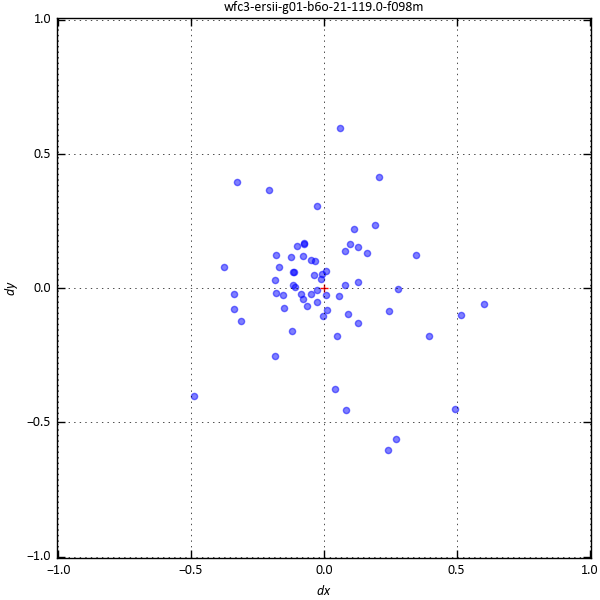

In [8]:
from IPython.display import Image
Image(filename = "./wfc3-ersii-g01-b6o-21-119.0-f098m_wcs.png", width=600, height=600)

In [9]:
!ls *_wcs.*
print('')
!cat *wcs.log

wfc3-ersii-g01-b6o-21-119.0-f098m_wcs.fits
wfc3-ersii-g01-b6o-21-119.0-f098m_wcs.log
wfc3-ersii-g01-b6o-21-119.0-f098m_wcs.png
wfc3-ersii-g01-b6o-23-119.0-f140w_wcs.fits
wfc3-ersii-g01-b6o-23-119.0-f140w_wcs.log
wfc3-ersii-g01-b6o-23-119.0-f140w_wcs.png

# ext xshift yshift rot scale rms N
# wfc3-ersii-g01-b6o-21-119.0-f098m
    0       -3.2194        2.6153       -0.0019       1.00001         0.144   65
# ext xshift yshift rot scale rms N
# wfc3-ersii-g01-b6o-23-119.0-f140w
    0       -3.1930        2.8373        0.0097       0.99998         0.070   92


### Grism sky subtraction ###

The grism sky backgrounds are subtracted using the "Master sky" images from [Brammer, Ryan, & Pirzkal 2015](http://www.stsci.edu/hst/wfc3/documents/ISRs/WFC3-2015-17.pdf) (available [here](http://www.stsci.edu/hst/wfc3/analysis/grism_obs/calibrations/wfc3_grism_master_sky.html)).  

`Grizli` ignores any wavelength dependence of the flat-field and applies a grey correction using the F140W (F105W) flat-field for the G141 (G102) grisms.

Residuals after subtracting the master sky images are typically of order 0.005 e-/s, just 0.5-1% overall background level.  They are removed by subtracting a column-average of the sky pixels in the grism exposures, and the processing script produces a diagnostic figure like the one shown below.  The source of the residuals is still unclear (e.g., perhaps spectra of objects near/below the detection limit).  Though they are usually well removed by the column average, they do make extracting continuum spectra of faint sources challenging.

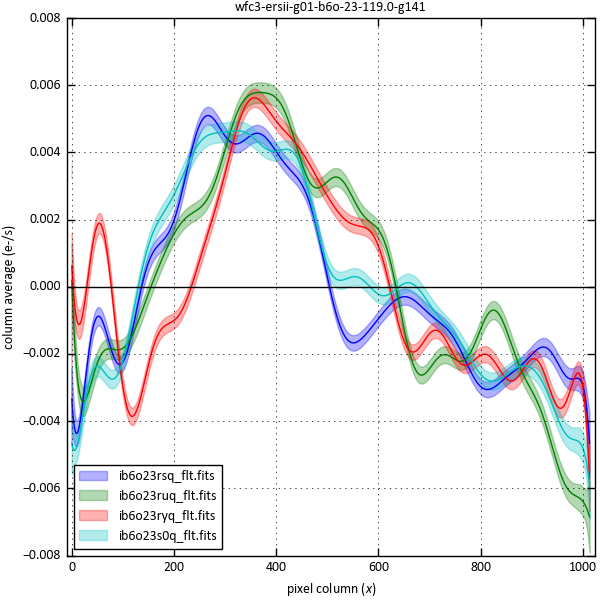

In [10]:
from IPython.display import Image
Image(filename = "./wfc3-ersii-g01-b6o-23-119.0-g141_column.png", width=600, height=600)

## `GroupFLT`: Container object for multple grism FLTs ##

With the preprocessing done, we can now start on the analysis of the spectra.  `Grizli` is built around low-level tools for modeling and analyzing each individual grism exposure individually.  Though once multiple exposures are available (e.g., exposures within a visit or separate visits with different grisms and/or orients) the information from each can be combined for analyzing the spectrum of a given object.  A benefit of the exposure-level processing is that all of the model-to-data comparisons (i.e. chi-squared) are done in the space of the original detector pixels, with their well-calibrated and well-understood noise properties.

The `GroupFLT` class provides a container for processing multiple FLT exposures simultanously.

### Inputs ###
* `grism_files` = list of grism exposure filenames
* `direct_files` = (optional) list of direct exposure filenames
* `ref_file` = (optional) reference direct image mosaic (one or the other of `ref_file` or `direct_files` should be specified.)
* `seg_file`, `catalog` = segmentation image and catalog, usually generated with SExtractor
* `cpu_count` = set to > 0 for parallel processing
* `pad` parameter (default=200 pixels).  If set, then add padding around the FLTs to enable modeling of objects that would fall off of the direct image but that still disperse spectra onto the grism exposure (assuming they fall in the `ref_file` and `seg_file` mosaics).

The contents of the `grism_files` list can contain pretty much anything, with the result limited by memory / cpu power.  For example, you can provide a list of **all** 112 of the 3D-HST G141 exposures in the COSMOS field (4 exposures x 28 pointings), along with the field mosaic and segmentation images.  This example is actually fairly easy to process as individual objects will fall in typically 4, perhaps 8 individual exposures in some overlap areas.  Another example is a list of exposures from multiple instruments / grisms / orients of a single field, thought the subsequent fits can be slow if an object has spectra in many individual exposures.

Reference images are blotted to the distorted exposure frame with `AstroDrizzle.ablot`.   Messages go by, as below, when you load the `GroupFLT` object talking about "cutouts" because the script tries to make smaller cutouts of large reference images to speed up the blot processing.

**NB** Seems to often have memory leak problems if `seg_file` isn't significantly larger than the footprint of a given FLT file.  Drizzle `blot` segfaults out but the script just hangs since the multiprocessing threads don't get the message.

In [5]:
from grizli.multifit import GroupFLT, MultiBeam, get_redshift_fit_defaults

all_grism_files = []
for i in range(len(visits)):
    if '-g1' in visits[i]['product']:
        all_grism_files.extend(visits[i]['files'])
        
grp = GroupFLT(grism_files=all_grism_files, direct_files=[], 
              ref_file='../Catalog/ERS_goodss_3dhst.v4.0.F160W_orig_sci.fits',
              seg_file='../Catalog/ERS_GOODS-S_IR.seg.fits',
              catalog='../Catalog/ERS_GOODS-S_IR.cat',
              cpu_count=8)

Image cutout: x=slice(0, 3600, None), y=slice(0, 3250, None) [Out of range]
ib6o21qmq_flt.fits / blot reference ../Catalog/ERS_goodss_3dhst.v4.0.F160W_orig_sci.fits[0]
Image cutout: x=slice(0, 3600, None), y=slice(0, 3250, None) [Out of range]
ib6o21r6q_flt.fits / blot reference ../Catalog/ERS_goodss_3dhst.v4.0.F160W_orig_sci.fits[0]
Image cutout: x=slice(0, 3600, None), y=slice(0, 3250, None) [Out of range]
ib6o21qoq_flt.fits / blot reference ../Catalog/ERS_goodss_3dhst.v4.0.F160W_orig_sci.fits[0]
Image cutout: x=slice(0, 3600, None), y=slice(0, 3250, None) [Out of range]
Image cutout: x=slice(0, 3600, None), y=slice(0, 3250, None) [Out of range]
ib6o23rsq_flt.fits / blot reference ../Catalog/ERS_goodss_3dhst.v4.0.F160W_orig_sci.fits[0]
ib6o23ruq_flt.fits / blot reference ../Catalog/ERS_goodss_3dhst.v4.0.F160W_orig_sci.fits[0]
Image cutout: x=slice(0, 3600, None), y=slice(0, 3250, None) [Out of range]
ib6o23s0q_flt.fits / blot reference ../Catalog/ERS_goodss_3dhst.v4.0.F160W_orig_sci.

### Flat continuum model ###

Once the `GroupFLT` object is initialized, compute a first-pass model of the full detector field of view assuming simple linear continua for all objects in the field (brighter than `mag_limit`).  By default this assumes a somewhat blue continuum suitable for the Rayleigh-Jeans tail of low-redshift objects.  It's far from perfect but the initial model does provide a good way of at least identifying which pixels of a given object could be contaminated by neighbors, even if the quantitative model is not precise.

In [6]:
# Compute the flat continuum model
grp.compute_full_model(mag_limit=25)

ib6o21qmq_flt.fits: _compute_model Done
ib6o23rsq_flt.fits: _compute_model Done
ib6o21qoq_flt.fits: _compute_model Done
ib6o21r6q_flt.fits: _compute_model Done
ib6o21r8q_flt.fits: _compute_model Done
ib6o23ruq_flt.fits: _compute_model Done
ib6o23ryq_flt.fits: _compute_model Done
ib6o23s0q_flt.fits: _compute_model Done
Models computed - 12.27 sec.


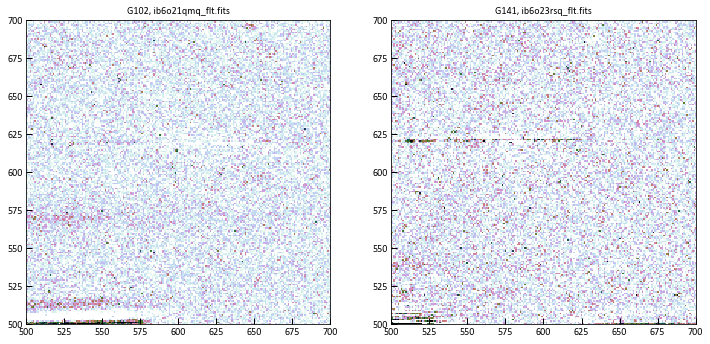

In [9]:
### Show FLT residuals
fig = plt.figure(figsize=[12,6])
ax = fig.add_subplot(121)
ax.imshow(grp.FLTs[0].grism['SCI'] - grp.FLTs[0].model, vmin=-0.02, vmax=0.2, cmap='cubehelix_r',
          interpolation='Nearest', origin='lower')
ax.set_title('G102, %s' %(grp.FLTs[0].grism.parent_file))

ax = fig.add_subplot(122)
ax.imshow(grp.FLTs[4].grism['SCI'] - grp.FLTs[4].model, vmin=-0.02, vmax=0.2, cmap='cubehelix_r',
          interpolation='Nearest', origin='lower')
ax.set_title('G141, %s' %(grp.FLTs[4].grism.parent_file))

for ax in fig.axes:
    ax.set_xlim(500,700); ax.set_ylim(500,700)

### Refined polynomial continuum model ###

After computing the simple continuum model, refine the model spectra for brighter objects using higher-order polynomials fit directly to the spectra themselves.  The `refine_list` method marches through objects starting with the brightest and fits a polynomial of order `poly_order` to the observed spectrum after subtracting off the model for contaminants.  Note that if the list of grism exposures contained multiple orientations covering a single field, this fit can be well constrained even in the presence of contamination.

In [8]:
### Refine the (polynomial) continuum model for brighter objects
grp.refine_list(poly_order=2, mag_limits=[16, 24], verbose=False)

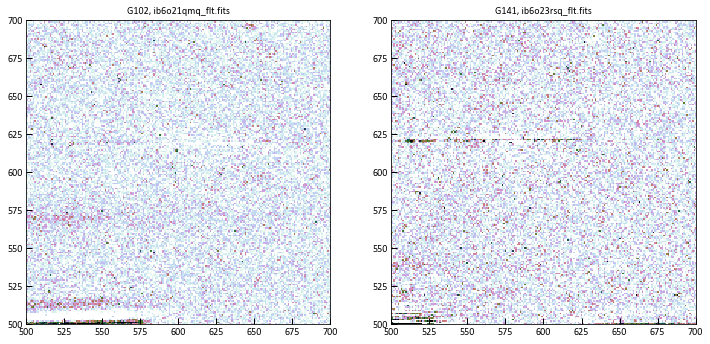

In [10]:
### Show FLT residuals
fig = plt.figure(figsize=[12,6])
ax = fig.add_subplot(121)
ax.imshow(grp.FLTs[0].grism['SCI'] - grp.FLTs[0].model, vmin=-0.02, vmax=0.2, cmap='cubehelix_r',
          interpolation='Nearest', origin='lower')
ax.set_title('G102, %s' %(grp.FLTs[0].grism.parent_file))

ax = fig.add_subplot(122)
ax.imshow(grp.FLTs[4].grism['SCI'] - grp.FLTs[4].model, vmin=-0.02, vmax=0.2, cmap='cubehelix_r',
          interpolation='Nearest', origin='lower')
ax.set_title('G141, %s' %(grp.FLTs[4].grism.parent_file))

for ax in fig.axes:
    ax.set_xlim(500,700); ax.set_ylim(500,700)

### Save state ###
You can optionally dump saved data for fast restart and avoid recomputing the contamination models, for example in a new Python session.  This can be done at any time after you've made changes to the GroupFLT data that you'd like to store for later.

In [16]:
grp.save_full_data()

Save ib6o21qmq_GrismFLT.fits
Save ib6o21qoq_GrismFLT.fits
Save ib6o21r6q_GrismFLT.fits
Save ib6o21r8q_GrismFLT.fits
Save ib6o23rsq_GrismFLT.fits
Save ib6o23ruq_GrismFLT.fits
Save ib6o23ryq_GrismFLT.fits
Save ib6o23s0q_GrismFLT.fits


In [17]:
# This will now be much faster and contains the full "refined" model
grp = GroupFLT(grism_files=all_grism_files, direct_files=[], 
              ref_file='../Catalog/ERS_goodss_3dhst.v4.0.F160W_orig_sci.fits',
              seg_file='../Catalog/ERS_GOODS-S_IR.seg.fits',
              catalog='../Catalog/ERS_GOODS-S_IR.cat',
              cpu_count=8)

Load ib6o21qmq_GrismFLT.fits!
Load ib6o21qoq_GrismFLT.fits!
Load ib6o21r6q_GrismFLT.fits!
Load ib6o21r8q_GrismFLT.fits!
Load ib6o23rsq_GrismFLT.fits!
Load ib6o23ruq_GrismFLT.fits!
Load ib6o23ryq_GrismFLT.fits!
Load ib6o23s0q_GrismFLT.fits!
Files loaded - 4.32 sec.


## Fitting individual spectra ##
Now we're done with the preprocessing and can get on with analyzing spectra.

The `GroupFLT` object contains the entire exposure information, from which we can make cutouts of spectra for individual objects with the `get_beams` method.  These cutouts are more managable than the entire exposures, though currently the processing does work in the paradigm of having a static contamination model for a given object.  

Redshift fits are performed in the following steps:

* On a coarse redshift grid (dz/1+z ~ 0.005) fit continuum templates along with **line complex** templates for a) [OII]+[NeIII], b) [OIII]+Hbeta, and c) Halpha+[SII]+weaker red lines.  These line complexes have fixed line ratios but are useful for breaking redshift degeneracies as these lines do, usually, come in groups.  Leaving all line strengths free would allow for perfect degeneracy between, e.g., Halpha and [OII] (assuming no significant continuum features).

* Find peaks (minima) in the chi-squared on the coarse grid and zoom in on them now allowing for more freedom in the indifidual line strengths, as well as fitting on a fine redshift grid sufficient to resolve the best redshift.

**NB** Continuum templates are needed in the directory `${GRIZLI}/templates`.  The template names are currently hard-coded in [multifit.py](https://github.com/gbrammer/grizli/blob/master/grizli/multifit.py) and the easiest way to make them available is to symlink them from the `data/templates` directory that accompanies the `grizli` code distribution:

```bash
# BASH
dist=`python -c "import grizli; print grizli.__file__"`
template_dir=`echo $dist | sed "s/__init__.pyc/data\/templates/"`
echo $template_dir
cd $GRIZLI
ln -s $template_dir ./
```


In [28]:
## Fit parameters
pzfit, pspec2, pline = get_redshift_fit_defaults()

# Redshift fit
pzfit ['zr'] = [0.5, 2.4]
pzfit['dz'] = [0.005, 0.0005]

# Drizzled line maps
pline = {'kernel': 'square', 'pixfrac': 0.6, 'pixscale': 0.06, 'size': 20}

# Full rectified 2D spectrum
pspec2 = {'NY': 20, 'dlam': 40, 'spatial_scale': 1}

### Object with emission lines ####

The example below shows how to extract the individual "beams" from the `GroupFLT` object and pass them to the `MultiBeam` object, which contains all the tools necessary for fitting the separate spectra together.  The basic redshift fit is wrapped into a single script `run_full_diagnostics`.

**NB** Because we provided the 3D-HST GOODS-S segmentation image and detection catalogs above, the ID numbers below all correspond directly to objects with the same ID in the 3D-HST catalogs and spectral products.

The first object shown below contains clear emission lines in both G141 ([OIII]) and G102 ([OII]) grisms.  The wrapper script produces the following files for each object:

* *ers-grism_zfit_40776.2D.fits*  - Fully combined 2D spectrum with SCI and WHT extensions along with additional extensions the CONTINUUM and FULL model spectra.  The trace has been rectified to lie parallel to image rows.
* *ers-grism_zfit_40776.2D.png*   - The green/yellow figure shown below
* *ers-grism_zfit_40776.beams.dat* - Information on the geometry of the spectrum cutouts
* *ers-grism_zfit_40776.fit.dat*  - Fit information (redshift, line fluxes)
* *ers-grism_zfit_40776.fit.npy*  - Additional data from the fit (template coefficients, best-fit model, etc.)
* *ers-grism_zfit_40776.line.fits* - 2D narrow-band line maps (see below)
* *ers-grism_zfit_40776.png* - The 1D spectrum figure shown below


First iteration: z_best=1.7469

 Zoom iteration: z_best=1.7420

Drizzle line -> OIII (15.36 1.00)
Drizzle line -> Hb   (3.60 0.84)
Drizzle line -> OII  (9.50 1.12)


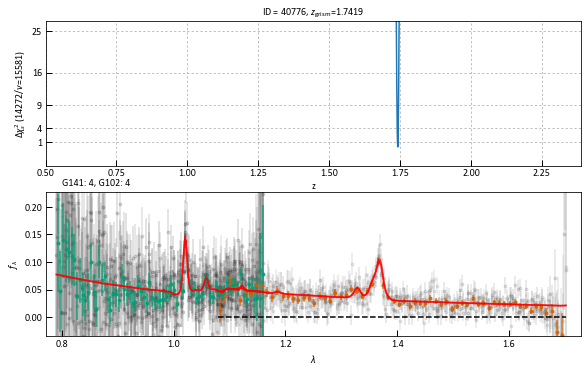

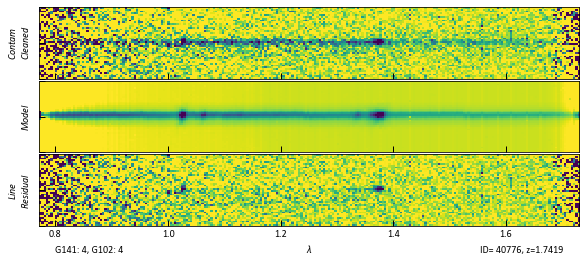

In [33]:
import grizli.multifit
#reload(grizli.multifit)
from grizli.multifit import GroupFLT, MultiBeam, get_redshift_fit_defaults

id=40776
# Extract spectrum cutouts from individual FLTs
beams = grp.get_beams(id, size=80)

# Put them in a `MultiBeam` object
mb = MultiBeam(beams, fcontam=1, group_name='ers-grism')

# Run the redshift fit and generate the emission line map
out = mb.run_full_diagnostics(pzfit=pzfit, pspec2=pspec2, pline=pline,
                              GroupFLT=grp, prior=None, verbose=False)

fit, fig, fig2, hdu2, hdu_line = out

### Emission line maps ###

Once we've computed the full continuum + line model, we can create 2D *drizzled* maps at any desired output wavelength, for example to make emission line maps.  This makes use of the WCS information in the individual grism FLT exposures and the outputs can have any desired WCS (e.g., pixel scale & dimensions) and can be used to compare directly to imaging data.

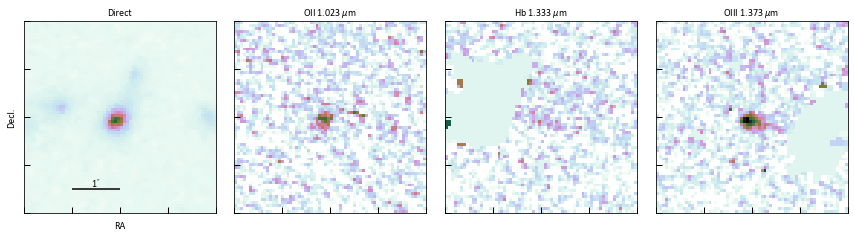

In [41]:
# Emission line maps
im = pyfits.open('ers-grism_40776.line.fits')
fig = plt.figure(figsize=[12,3])

# Direct
ax = fig.add_subplot(141)
ax.imshow(im['DSCI'].data, vmin=-0.02, vmax=0.4, cmap='cubehelix_r', origin='lower')
ax.set_title('Direct')
ax.set_xlabel('RA'); ax.set_ylabel('Decl.')

# 1" ticks
from matplotlib.ticker import MultipleLocator
pix_size = np.abs(im['DSCI'].header['CD1_1']*3600)
majorLocator = MultipleLocator(1./pix_size)
N = pline['size']/pix_size/2
ax.errorbar([N-0.5/pix_size], N-1.5/pix_size, yerr=0, xerr=0.5/pix_size, color='k')
ax.text(N-0.5/pix_size, N-1.5/pix_size, r'$1^{\prime\prime}$', ha='center', va='bottom', color='k')

# Line maps
for i, line in enumerate(['OII', 'Hb', 'OIII']):
    ax = fig.add_subplot(142+i)
    ax.imshow(im['LINE',line].data, vmin=-0.02, vmax=0.3, cmap='cubehelix_r', origin='lower')
    ax.set_title(r'%s %.3f $\mu$m' %(line, im['LINE', line].header['WAVELEN']/1.e4))

# End things
for ax in fig.axes:
    ax.set_yticklabels([]); ax.set_xticklabels([])
    ax.set_xlim(N+np.array([-2,2])/pix_size)
    ax.set_ylim(N+np.array([-2,2])/pix_size)
    
    ax.xaxis.set_major_locator(majorLocator)
    ax.yaxis.set_major_locator(majorLocator)
    
fig.tight_layout(pad=0.5)

### Continuum-dominated spectra ###

The object below is the dominated by strong Balmer break and absorption lines (see [van Dokkum & Brammer 2010](http://adsabs.harvard.edu/abs/2010ApJ...718L..73V)).  The redshift fit and spectral constraints are precise even without any supporting photometric data.

First iteration: z_best=1.9022

 Zoom iteration: z_best=1.9002

Drizzle line -> OIII (2.68 1.55)
Drizzle line -> Hb   (2.80 1.41)


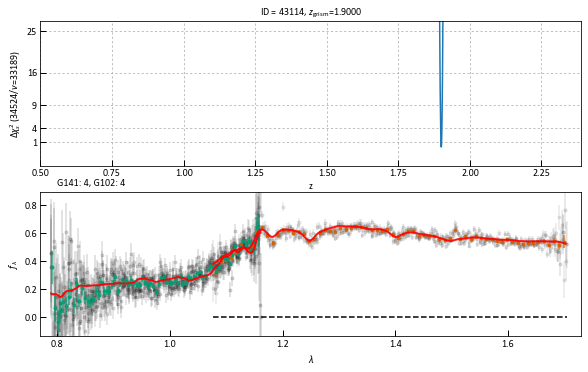

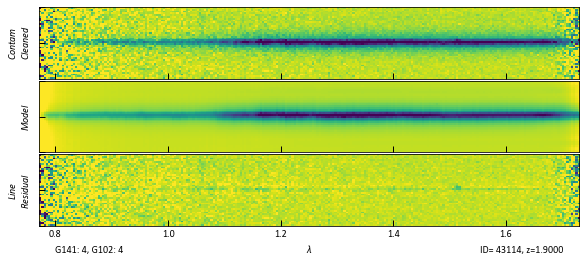

In [32]:
id=43114
beams = grp.get_beams(id, size=80)
mb = MultiBeam(beams, fcontam=1, group_name='ers-grism')
out = mb.run_full_diagnostics(pzfit=pzfit, pspec2=pspec2, pline=pline,
                              GroupFLT=grp, prior=None, verbose=False)

### Weaker continuum features ###

With sufficient S/N, precise redshifts can be determined from the continuum alone even without photometric constraints.  The object below has a ground-based spectroscopic redshift z=0.735.

First iteration: z_best=0.7341

 Zoom iteration: z_best=0.7368

Drizzle line -> Ha   (4.14 1.13)
Drizzle line -> OIII (4.22 3.33)


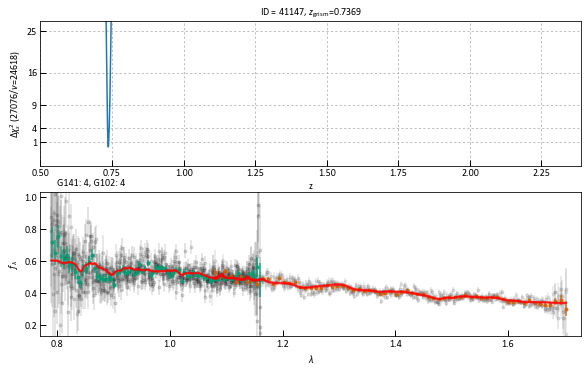

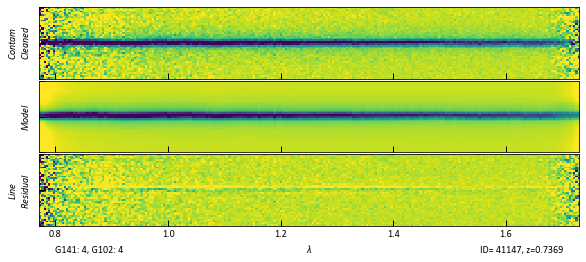

In [34]:
# Continuum, weak features
id=41147 # z_spec = 0.735
beams = grp.get_beams(id, size=80)
mb = MultiBeam(beams, fcontam=1, group_name='ers-grism')
out = mb.run_full_diagnostics(pzfit=pzfit, pspec2=pspec2, pline=pline,
                              GroupFLT=grp, prior=None, verbose=False)

### Stars ### 

Point sources are usually fairly easy to distinguish in HST imaging alone.  The `MultiBeam` object provides a separate method for performing fits with stellar templates (e.g., Pickles, BPGS, SpeX libraries, fixed to z=0).  

In [38]:
from imp import reload
reload(grizli.multifit)
from grizli.multifit import MultiBeam

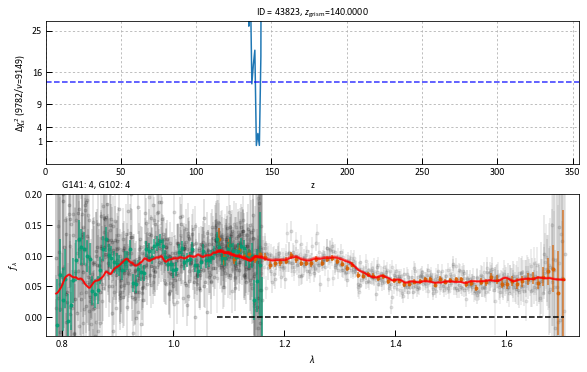

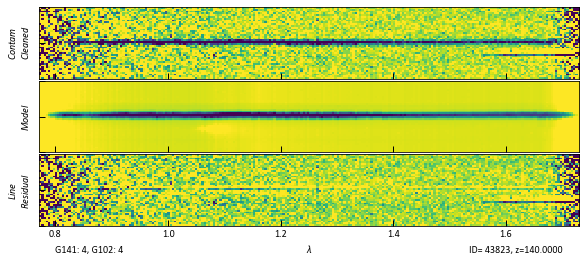

In [39]:
# star
pzfit ['zr'] = 0 # toggle stellar fit
id = 43823
beams = grp.get_beams(id, size=80)
mb = MultiBeam(beams, fcontam=1, group_name='ers-grism', psf=False)
#mb.write_beam_fits()
out = mb.run_full_diagnostics(pzfit=pzfit, pspec2=pspec2, pline=pline,
                              GroupFLT=grp, prior=None, verbose=False)

**EXPERIMENTAL:** Use the WFC3 ["Effective PSF"](http://www.stsci.edu/hst/wfc3/analysis/PSF) as the morphological reference.  This method fits the ePSF model to the direct image at the wavelength of the direct imaging filter and then uses the filter/wavelelength dependent ePSF to interpolate along the trace.  Note that the residuals in the 2D spectrum of the fit below are significantly reduced compared to the previous fit, where the residuals were smallest only near the central wavelength of the direct imaging filter (F140W). 

*NB:* This currently only works with the `BeamCutout` and `MultiBeam` objects.  It's not able to project the ePSF model spectra back to the global contamination model.

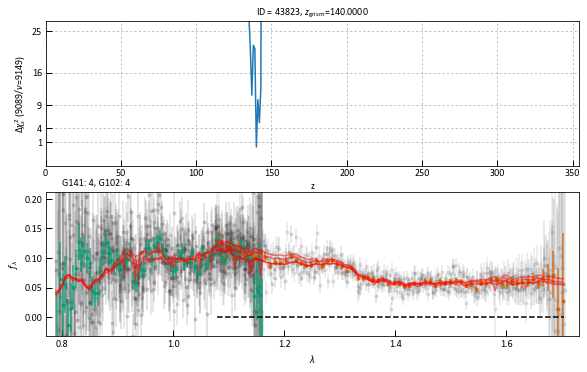

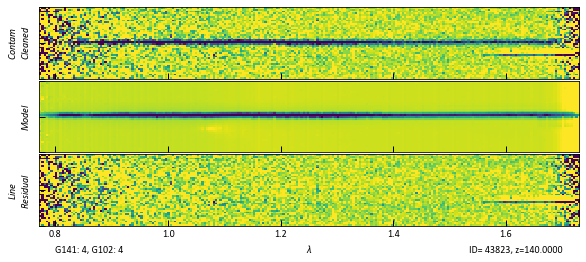

In [40]:
# star
pzfit ['zr'] = 0 # toggle stellar fit
id = 43823
beams = grp.get_beams(id, size=80)
mb = MultiBeam(beams, fcontam=1, group_name='ers-grism', psf=True)
#mb.write_beam_fits()
out = mb.run_full_diagnostics(pzfit=pzfit, pspec2=pspec2, pline=pline,
                              GroupFLT=grp, prior=None, verbose=False)